# Classify pattern defects of Rayleigh-Benard convection

This notebook uses SIFT feature vectors and Hough transform voting to find matches from a dictionary of defects in input patterns. The info for the Hough transform voting is from http://conf-scoop.org/IWIP-2014/4.V.Seib_IWIP.pdf

In [9]:
import numpy as np
import scipy
from scipy.cluster import hierarchy as hc
import pandas as pd
from skimage import morphology
from scipy import misc
from matplotlib import pyplot as plt
import math, time
from skimage import measure
from scipy import signal
from scipy.ndimage.filters import gaussian_filter
from scipy import spatial
from scipy.cluster.hierarchy import dendrogram, linkage


import warnings
warnings.filterwarnings('ignore')


%matplotlib inline  

## Set up local environment variables

In [10]:
sDir = '/Users/birdbrain/Documents/Research/Projects/Schatz/Data/g21chaotic'
centerx = 210 # Center-x of circular crop
centery = 210 # Center-y of circular crop
roll_width = 30 # Width of a single roll
crop_radius = 210-roll_width # Radius of circular crop
keypoint_orientation_bins = 19


sFeatureVectors = ['/r4000_2016_11_01_superfast/g21flow/feature_vectors_3/%06d.txt', '/r4000_2016_02_04_superfast/g21flow/feature_vectors_3/%05d.txt']
sBmp = ['/r4000_2016_11_01_superfast/g21flow/bmps/%06d.bmp', '/r4000_2016_02_04_superfast/g21flow/BMPs_sublevel/%05d.bmp']

sFeatureVectors[1] = sFeatureVectors[0]
sBmp[1] = sBmp[0]

## Set up variables for local defect computations

In [11]:
radius = roll_width

## Utility functions

In [12]:
def loadData(idx, dataset):
    
    # Get feature vectors
    fv = pd.read_csv(sDir + "/" + (sFeatureVectors[dataset] % idx), sep=' ', header=None)
    fv = fv.astype(np.int16)
    
    # Get bitmap image
    bmp = misc.imread(sDir + "/" + sBmp[dataset] % idx)

    return (fv, bmp)


In [13]:
def computeMatch(_location, _fv1, _fv2, _radius, _location_bins, _rotation_bins, _cutoff, _num_features_factor, _makeplots):
    """Compute the distance between two patterns based on their keypoint features.
    Based on using Hough transform voting to find clusters of matches which align with the same
    relative orientation to the center of the pattern.

    Arguments:
    location1 -- the (x,y) location of the first pattern center
    fv1 -- The feature vector (with index, (x,y) location, type vector, and orientation) for the first pattern
    fv2 -- The feature vector (with index, (x,y) location, type vector, and orientation) for the second pattern
    """
    
    boxradius = _radius # For Hough transform
    
    ht_vectors = []
    ht_accumulator = []
    
    feature_index = 14
    
    x1 = int(_location[0])
    y1 = int(_location[1])
    time1 = int(_fv1[0,0])
    time2 = int(_fv2[0,0])
    
    if _makeplots:
        plt.rcParams['figure.figsize'] = (15.0, 3.0)
        plt.subplot(1,2,1)
        bmp1 = bmps[time1][(y1-boxradius):(y1+boxradius), (x1-boxradius):(x1+boxradius)]
        plt.imshow(bmp1)
        plt.scatter(_fv1[:,1] - x1 + boxradius, _fv1[:,2] - y1 + boxradius, color='white', edgecolor='black')
        
        plt.subplot(1,2,2)
        bmp2 = bmps[time2]
        plt.imshow(bmp2)
        plt.scatter(_fv2[:,1], _fv2[:,2], color='white', edgecolor='black')
        
        plt.show()
    
        plt.rcParams['figure.figsize'] = (15.0, 3.0)
    
    _dist = 300
    
    
    # Match on the local keypoint descriptor
    # Loop through the features in the second feature vector
    for i in range(_fv1.shape[0]):
        
        if _makeplots:
            print "Feature #%d" % i
        
        # Only keypoints with same type should be matched
        keypoint_type = np.argwhere(_fv1[i,3:11]==1)
        fv2_sametype = _fv2[np.where(_fv2[:,keypoint_type+3]==1)[0], :]
        
        # If there's at least one keypoint with the same type:
        if len(fv2_sametype)>0:
            
            allfv = np.vstack((_fv1[i,:], fv2_sametype))
            allfv = allfv[:,feature_index:]

            # Get the nearest neighbors
            num_neighbors = 10
            distmat = spatial.distance.pdist(allfv)
            distmat = spatial.distance.squareform(distmat)
            sorted_distances = sorted((e,i) for i,e in enumerate(distmat[0,1:]))
            sorted_distances = np.asarray(sorted_distances)
            nn = sorted_distances[0:num_neighbors, :]

            
            if _makeplots:
                print nn.T
                bmp0 = bmps[time1][(_fv1[i,2] - boxradius):(_fv1[i,2] + boxradius), (_fv1[i,1] - boxradius):(_fv1[i,1] + boxradius)]
                plt.subplot(1,num_neighbors+1,1)
                plt.imshow(bmp0);
                plt.scatter(boxradius, boxradius, color='white', edgecolor='black');
            
            display_neighbors = 10
            for n in range(min(display_neighbors, len(nn[:,0]))):
                matched_nn = fv2_sametype[nn[n,1],:]
                
                if _makeplots:
                    bmp_match = bmps[time2][(matched_nn[2] - boxradius):(matched_nn[2] + boxradius), (matched_nn[1] - boxradius):(matched_nn[1] + boxradius)]

                    plt.subplot(1,num_neighbors+1,n+2)
                    plt.imshow(bmp_match);
                    plt.scatter(boxradius, boxradius, color='white', edgecolor='black');

            if _makeplots:
                plt.show();
                
            # Do the Hough transform stuff
            # Get the nearest neighbor distance
            cutoff_distance = nn[0,0] + _cutoff
            
            nn = nn[nn[:,0]<= cutoff_distance,:]
            
            for this_nn in range(nn.shape[0]):
                
                nbr = nn[this_nn,:]

                # For this nearest neighbor
                matched_nn = fv2_sametype[nbr[1],:]

                # Get the translation vector from the original image
                v_prime = [x1, y1] - _fv1[i,1:3]

                # Rotate by the orientations
                alpha = math.radians(abs(_fv1[i,9] - matched_nn[9])*(180./keypoint_orientation_bins))
                v = np.dot(np.asarray([[math.cos(alpha), -math.sin(alpha)], [math.sin(alpha), math.cos(alpha)]]), v_prime)

                # Compute the estimated centroid of the matched image
                c_s = v + matched_nn[1:3]

                # Center it at zero
                c_s_centered = c_s - np.asarray([x1, y1])

                # Bin the centroid values
                c_accum = np.floor(c_s_centered*(float(_location_bins)/float(_radius)))
                c_accum_p1 = c_accum + 1

                # Get the orientation vote
                i_r_prime = (alpha + math.pi)*_rotation_bins*(1./(2.*math.pi))

                # Bin it
                r_accum = math.floor(i_r_prime) % _rotation_bins
                r_accum_p1 = math.floor(i_r_prime+1) % _rotation_bins

                # Make a vector out of it
                accum = np.hstack(( [i], c_accum, c_accum_p1, [r_accum], [r_accum_p1], [nbr[0]], matched_nn[1:3], c_s))

                # Add it to the hough transform vector
                if len(ht_vectors) == 0:
                    ht_vectors = accum

                else:
                    ht_vectors = np.vstack((ht_vectors, accum))

                # Add it to the hough transform accumulator
                for _x in [1,3]:
                    for _y in [2,4]:
                        for _r in [5,6]:
                            if len(ht_accumulator) == 0:
                                ht_accumulator = np.hstack((np.asarray([accum[0], accum[_x], accum[_y], accum[_r]]), accum[7:12]))
                            else:
                                ht_accumulator = np.vstack((ht_accumulator, np.hstack((np.asarray([accum[0], accum[_x], accum[_y], accum[_r]]), accum[7:12]))))
                
    if len(ht_accumulator) > 0:
        
        # Get the bin with the highest vote
        tmp_accumulator = ht_accumulator[:,1:4]
        b = np.ascontiguousarray(tmp_accumulator).view(np.dtype((np.void, tmp_accumulator.dtype.itemsize * tmp_accumulator.shape[1])))
        _, idx, counts = np.unique(b, return_index=True, return_counts=True)
        top_ht = np.argsort(counts)

        sorted_accumulator = np.concatenate((tmp_accumulator[idx[top_ht]][::-1], np.reshape(counts[top_ht][::-1].T, (len(counts),1))), axis=1)
        
        highest_bin = sorted_accumulator[0,0:(sorted_accumulator.shape[1]-1)]

        # Get all the bins that are within one sup-norm distance away
        subtract_bin = np.matlib.repmat(highest_bin, tmp_accumulator.shape[0], 1)
        differences = np.abs(tmp_accumulator - subtract_bin)
        close_bins = ht_accumulator[np.argwhere(np.max(differences, axis=1)<=1),:]

        # Get the records corresponding to those bin values
        matching_records = np.reshape(close_bins, (close_bins.shape[0], close_bins.shape[2]))
        matching_records = matching_records[:,[0, -5, -4, -3, -2, -1]]
        tmp_matching_records = np.ascontiguousarray(matching_records).view(np.dtype((np.void, matching_records.dtype.itemsize * matching_records.shape[1])))
        _, idx = np.unique(tmp_matching_records, return_index=True)
        
        # Check to make sure enough keypoints are matched up
        if len(idx) >= _num_features_factor*_fv1.shape[0]:

            # Get the corresponding features and take the average distance and centroid
            matched_features = matching_records[idx, :]

            _dist = np.median(matched_features[:,1])
            _loc = np.mean(matched_features[:,[-2, -1]], axis=0)
            
            # Get the number of keypoints in the radius neighborhood of this location in the matched pattern
            
            # Get the features that are within the radius of the locations
            k2 = spatial.KDTree(_fv2[:, 1:3])

            # Get 50 nearest neighbors within radius
            nn2 = k2.query(_loc, k=50, distance_upper_bound=_radius)

            # Remove infinite matches
            nn2 = nn2[1]
            nn2 = nn2[(nn2<_fv2.shape[0])]

            # Make sure enough are matched
            if len(idx) > _num_features_factor*nn2.shape[0]:
            
                if _makeplots:
                    print matched_features

                    plt.rcParams['figure.figsize'] = (10.0, 10.0)
                    plt.imshow(bmp2)
                    plt.scatter(matched_features[:,2].astype(int), matched_features[:,3].astype(int), color='white', edgecolor='black')
                    plt.scatter(_loc[0], _loc[1], color='black', edgecolor='black')
                    plt.show()

                return (_dist, _loc)
            else:
                return (0,[])
            
        else:
            
        
            if _makeplots:

                plt.rcParams['figure.figsize'] = (10.0, 10.0)
                plt.imshow(bmp2)
                plt.show()
                
            return (0, [])
    

## Compute the distances between patterns from two nearby images

In [14]:
t1 = 1525
t2 = 1535

bmps = {}
features = []

for idx in [t1, t2]:

    fv, bmp = loadData(idx, 0)
    
    # Add bitmap image to dictionary, where idx is the key and the bitmap is the value
    bmps[idx] = bmp
    
    if len(features) == 0:
        features = fv
    else:
        features = np.vstack([features, fv])

features = features.astype(np.int16)

features1 = features[(features[:,0] == t1)]
features2 = features[(features[:,0] == t2)]
print features1.shape, features2.shape

(119, 110) (114, 110)


(array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), array([  3,   4,  61,  62,  63,  64,  65,  67,  70, 111, 112, 113]))


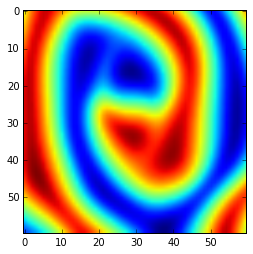

In [15]:
x = 135
y = 225

x = [x, x+2*radius]
y = [y, y+2*radius]


bmp_cropped = bmps[t1][y[0]:y[1], x[0]:x[1]]
plt.imshow(bmp_cropped)

print np.where([(features1[:,1] >= x[0]) & (features1[:,1] <= x[1]) & (features1[:,2] >= y[0]) & (features1[:,2] <= y[1])])

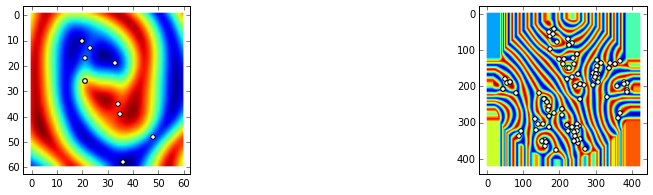

Feature #0
[[ 153.57408636  209.83564997  248.46327696  249.84795376  252.69546889
   261.05363434  262.13546116  268.64660802  268.82150212  270.19622499]
 [  51.           43.           36.           11.            2.           45.
     1.           39.           40.           23.        ]]


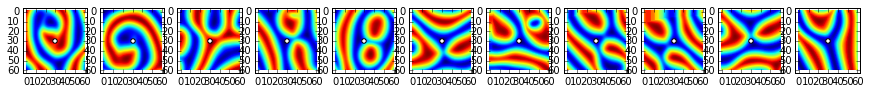

Feature #1
[[ 147.50593208  154.00649337  169.41664617  207.29447653  208.44663586
   209.75938596  219.93180761  226.60759034  230.42135318  235.11699215]
 [  29.           39.           23.           10.           14.            7.
    11.            1.           34.            9.        ]]


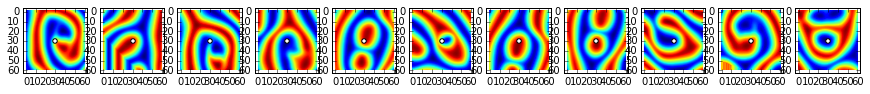

Feature #2
[[ 160.75447117  193.88914358  224.74207439  226.23881188  229.95651763
   232.08834525  238.83257734  240.95227743  247.07286375  248.76695922]
 [  19.           37.           32.            2.            8.           18.
    25.           24.           11.           17.        ]]


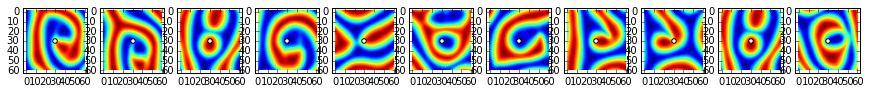

Feature #3
[[  68.9710084   183.70356556  200.95770699  222.19360927  231.12550703
   231.60094991  235.77531677  241.23639858  248.98795152  252.2360006 ]
 [  21.           31.           30.           40.            9.           34.
    15.           39.           29.           11.        ]]


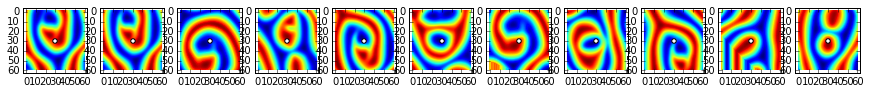

Feature #4
[[  99.57911428  195.61441665  203.74493859  207.55240302  224.01562446
   224.74207439  230.63607697  239.48903942  241.03526713  243.60829214]
 [  40.           21.           30.           15.           37.           34.
     9.           29.            8.           11.        ]]


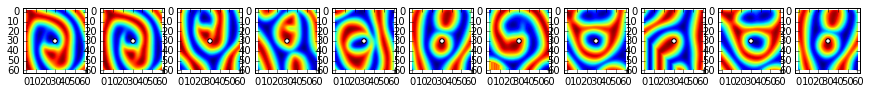

Feature #5
[[ 242.3262264   255.94530666  266.39819819  270.97970404  276.77246973
   279.7713352   282.28531666  284.17952073  284.27451521  289.33717355]
 [   2.           45.           39.            1.           42.           51.
     9.           10.            4.           50.        ]]


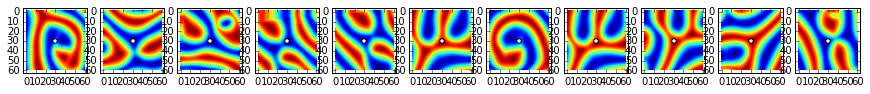

Feature #6
[[  84.84692098  217.4695381   219.7521331   221.09274072  224.04017497
   226.58993799  227.54340245  231.49946004  255.17640957  256.30840798]
 [   6.           12.           15.            3.            2.            0.
    16.           11.            7.           10.        ]]


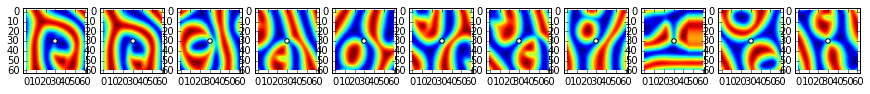

Feature #7
[[  71.09149035  203.9460713   206.15770662  218.94976593  223.35397915
   233.73275337  234.77435976  235.76471322  238.72997298  240.45789652]
 [  19.            8.           32.            5.           37.           18.
    17.           25.           22.           10.        ]]


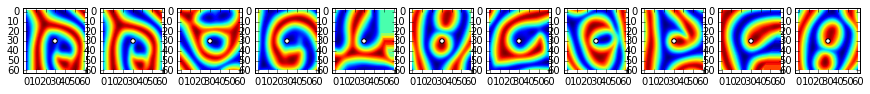

Feature #8
[[ 189.21416437  234.03632197  236.32816167  241.25090673  251.26082066
   256.06639764  257.25473757  257.71301869  259.06755876  262.42522745]
 [  39.           27.           15.           11.           34.           29.
    23.           14.            9.           35.        ]]


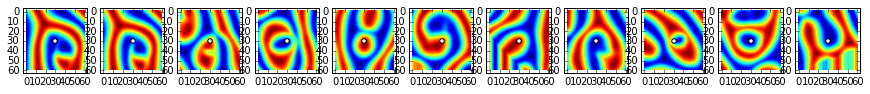

Feature #9
[[  45.13313639  117.28171213  196.07651568  208.33146666  208.81331375
   221.78367839  237.3394194   247.58029001  250.69104491  259.46290679]
 [   2.           16.            0.            7.           19.           12.
     6.           17.           15.            3.        ]]


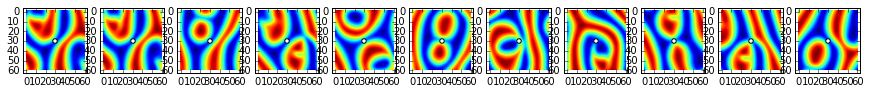

Feature #10
[[  48.66210024  213.95560287  226.43542126  249.57363643  253.67893093
   265.99812029  272.29212254  272.78746306  273.86858162  279.24899284]
 [  26.           39.           31.            1.           33.            2.
    21.           49.           27.           36.        ]]


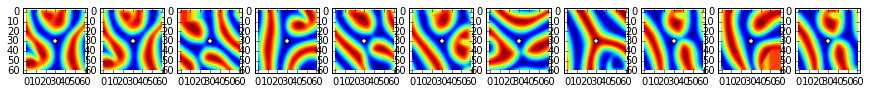

Feature #11
[[  53.07541804  196.26767436  222.7734275   223.31144171  249.85195617
   255.44471026  262.69944804  264.7394946   275.60660369  276.61887137]
 [  48.           10.           30.           20.           41.           12.
    18.            3.           50.            9.        ]]


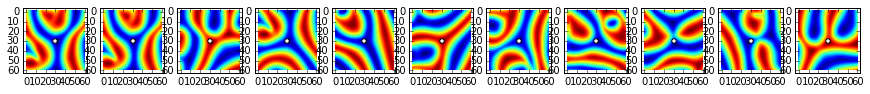

[[   3.           68.9710084   169.          264.          164.          255.        ]
 [   4.           99.57911428  166.          244.          163.          255.        ]
 [   6.           84.84692098  159.          234.          166.          251.        ]
 [   7.           71.09149035  157.          234.          167.          254.        ]
 [   8.          189.21416437  157.          234.          167.          254.        ]
 [   9.           45.13313639  184.          273.          166.          255.        ]
 [  10.           48.66210024  171.          283.          165.          255.        ]
 [  11.           53.07541804  171.          283.          165.          255.        ]]


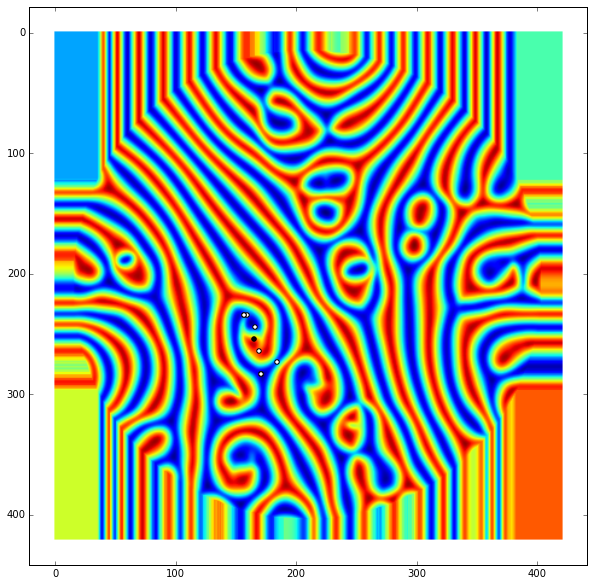

70.0312493754 [ 165.375  254.25 ]


In [17]:

location1 = np.asarray([np.average(x), np.average(y)])

# Get the features that are within the radius of the locations
k1 = spatial.KDTree(features1[:, 1:3])

# Get 50 nearest neighbors within radius
nn1 = k1.query(location1, k=50, distance_upper_bound=radius)

# Remove infinite matches
nn1 = nn1[1]
nn1 = nn1[(nn1<features1.shape[0])]

f1 = features1[nn1]
f2 = features2

(dist, location_match) = computeMatch(location1, f1, f2, radius, 10, 8, 100, .5, 1)

print dist, location_match

## Compute matches for a single pattern across a dataset

<function matplotlib.pyplot.show>

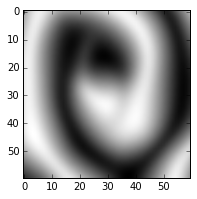

In [19]:
presets = [[1085, 120, 330], [1615, 275, 140], [1525, 135, 225]]

# Preset catalog
# 0 = duck head in spiral
# 1 = figure eight target
# 2 = distorted spiral

preset_idx = 2

t1 = presets[preset_idx][0]
x = presets[preset_idx][1]
y = presets[preset_idx][2]

x = [x, x+2*radius]
y = [y, y+2*radius]

features1, bmp1 = loadData(t1, 0)
features1 = np.asarray(features1)

plt.set_cmap('gray')
plt.rcParams['figure.figsize'] = (3.0, 3.0)
bmp_cropped = bmp1[y[0]:y[1], x[0]:x[1]]
plt.imshow(bmp_cropped)
plt.show

In [20]:

location1 = np.asarray([np.average(x), np.average(y)])

# Get the features that are within the radius of the locations
k1 = spatial.KDTree(features1[:, 1:3])

# Get 50 nearest neighbors within radius
nn1 = k1.query(location1, k=50, distance_upper_bound=radius)

# Remove infinite matches
nn1 = nn1[1]
nn1 = nn1[(nn1<features1.shape[0])]

f1 = features1[nn1]

1134 132.691371234 [ 164.          254.77777778]
1135 132.853302556 [ 164.          254.77777778]
1136 132.687603038 [ 164.          254.77777778]
1139 121.354851572 [ 164.11111111  254.55555556]
1140 121.354851572 [ 164.11111111  254.66666667]
1142 120.52385656 [ 164.11111111  254.66666667]
1143 119.983332176 [ 164.11111111  254.55555556]
1144 119.385928819 [ 164.11111111  254.55555556]
1145 119.457105272 [ 164.11111111  254.55555556]
1226 130.187502419 [ 165.1  255.9]
1227 138.585713549 [ 164.81818182  255.63636364]
1228 143.831945101 [ 165.   255.7]
1229 140.548923866 [ 164.90909091  255.36363636]
1230 140.691151108 [ 165.          255.36363636]
1231 141.880231181 [ 165.          255.36363636]
1233 106.794194599 [ 165.33333333  255.88888889]
1234 130.573140085 [ 165.   255.8]
1235 147.597160963 [ 164.9  255.5]
1236 125.596912838 [ 165.1  255.7]
1237 131.825278781 [ 164.9  255.7]
1238 123.749747474 [ 164.81818182  255.63636364]
1239 124.911969002 [ 164.63636364  255.72727273]
1240 12

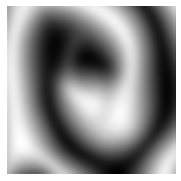

1336 99.242740199 [ 165.2  255.9]


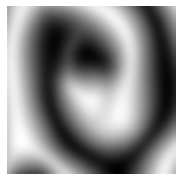

1339 77.8909494101 [ 165.33333333  256.        ]


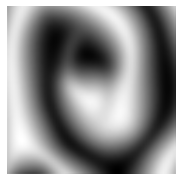

1340 79.1012010023 [ 165.11111111  256.11111111]


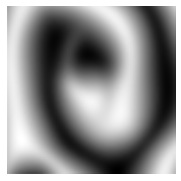

1341 80.4586739438 [ 165.3  256.2]


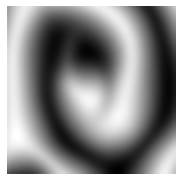

1440 59.2368128785 [ 165.33333333  255.11111111]


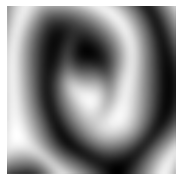

1442 71.2741187248 [ 165.33333333  255.        ]


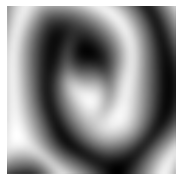

1443 72.6704891961 [ 165.22222222  255.55555556]


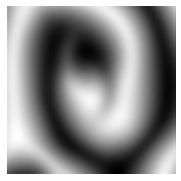

1444 85.2994724485 [ 165.22222222  255.55555556]


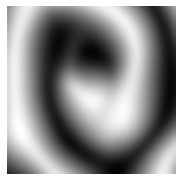

1522 32.3109888428 [ 164.88888889  255.11111111]


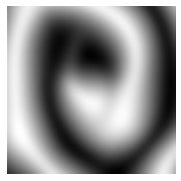

1523 22.825424421 [ 164.90909091  254.90909091]


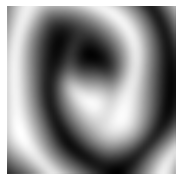

1524 12.8062484749 [ 164.81818182  254.90909091]


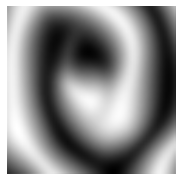

1525 0.0 [ 165.  255.]


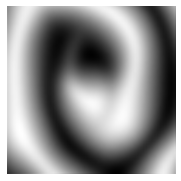

1526 10.9912704551 [ 164.91666667  254.91666667]


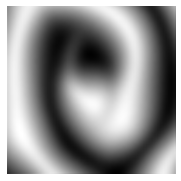

1527 27.2753223268 [ 164.91666667  254.75      ]


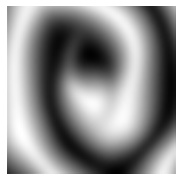

1528 38.5009235802 [ 164.91666667  254.66666667]


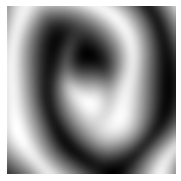

1529 50.8668671707 [ 165.16666667  254.58333333]


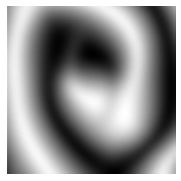

1616 70.6186944088 [ 164.77777778  254.66666667]


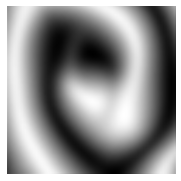

1617 66.2799421888 [ 164.8  254.8]


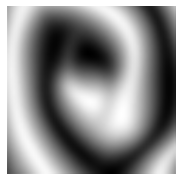

1618 70.4160522487 [ 165.1  254.5]


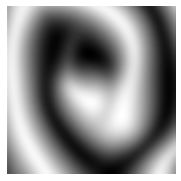

1619 63.5732761027 [ 165.2  254.4]


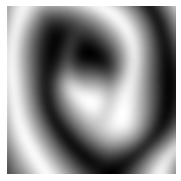

1620 60.904289027 [ 165.2  254.4]


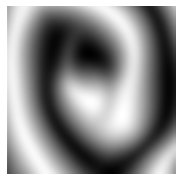

1621 66.2494440407 [ 165.1  254.3]


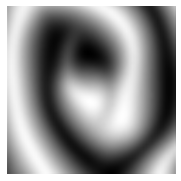

1623 97.508973946 [ 165.          254.66666667]
1624 116.0 [ 165.18181818  254.45454545]
1715 143.940960119 [ 165.22222222  254.66666667]
1716 148.393441546 [ 165.3  254.5]
1717 146.632192918 [ 165.33333333  254.44444444]
1718 153.996753213 [ 165.33333333  254.44444444]


In [26]:
output_matches = [0, 0]

print_cutoff = 100
index_range = [1000, 1999]

for t2 in range(index_range[0],index_range[1]):

    features2, bmp2 = loadData(t2, 1)
    features2 = np.asarray(features2)

    (dist, loc_match) = computeMatch(location1, f1, features2, radius, 10, 8, 100, .75, 0)
    
    if (len(loc_match) > 0):
        output_matches = np.vstack((output_matches, [t2, dist]))
        
        if dist <= print_cutoff:
            
            plt.set_cmap('gray')
            bmp_cropped = bmp2[(loc_match[1]-radius):(loc_match[1]+radius), (loc_match[0]-radius):(loc_match[0]+radius)]
            plt.imshow(bmp_cropped)
            
            plt.gca().xaxis.set_major_locator(plt.NullLocator())
            plt.gca().yaxis.set_major_locator(plt.NullLocator())

            plt.axis('off')

            plt.show()

        print t2, dist, loc_match

In [27]:
def consecutive(data, stepsize=5):
    return np.split(data, np.where(np.diff(data[:,0]) != stepsize)[0]+1, axis=0)

plot_matches = consecutive(output_matches[1:])

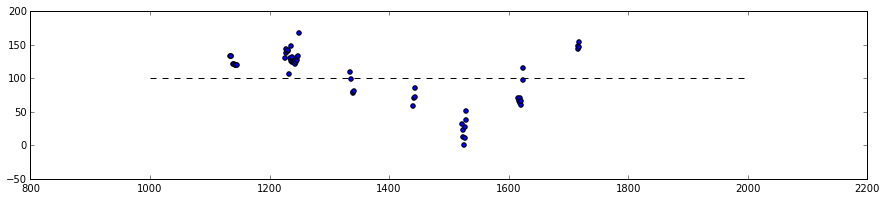

In [28]:

plt.rcParams['figure.figsize'] = (15.0, 3.0)
for i in range(len(plot_matches)):
    plt.plot(plot_matches[i][:, 0], plot_matches[i][:, 1], linewidth=2)
    plt.scatter(plot_matches[i][:, 0], plot_matches[i][:, 1], linewidth=1)
    
plt.plot(index_range, [print_cutoff, print_cutoff], '--k', linewidth=1)

## Generate a distance matrix based on Hough transform distance

<function matplotlib.pyplot.show>

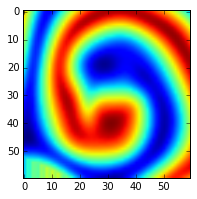

In [86]:
presets = [[1085, 120, 330], [1525, 135, 225]]

# Preset catalog
# 0 = Lower-left right-handed spiral
# 1 = Center-left left-handed spiral

preset_idx = 0

t1 = presets[preset_idx][0]
x = presets[preset_idx][1]
y = presets[preset_idx][2]

x = [x, x+2*radius]
y = [y, y+2*radius]

features1, bmp1 = loadData(t1, 0)
features1 = np.asarray(features1)

plt.rcParams['figure.figsize'] = (3.0, 3.0)
bmp_cropped = bmp1[y[0]:y[1], x[0]:x[1]]
plt.imshow(bmp_cropped)
plt.show

In [88]:

print_cutoff = 250
index_range = range(1000, 2000)

location = np.asarray([np.average(x), np.average(y)])

distmat = np.zeros((len(index_range),len(index_range)))

for t1 in range(len(index_range)):
    
    print index_range[t1]

    features1, bmp1 = loadData(index_range[t1], 0)
    features1 = np.asarray(features1)

    # Get the features that are within the radius of the locations
    k1 = spatial.KDTree(features1[:, 1:3])

    # Get 50 nearest neighbors within radius
    nn1 = k1.query(location, k=50, distance_upper_bound=radius)

    # Remove infinite matches
    nn1 = nn1[1]
    nn1 = nn1[(nn1<features1.shape[0])]

    f1 = features1[nn1]

    for t2 in range(t1, len(index_range)):

        features2, bmp2 = loadData(index_range[t2], 0)
        features2 = np.asarray(features2)

        # Get the features that are within the radius of the locations
        k2 = spatial.KDTree(features2[:, 1:3])

        # Get 50 nearest neighbors within radius
        nn2 = k2.query(location, k=50, distance_upper_bound=radius)

        # Remove infinite matches
        nn2 = nn2[1]
        nn2 = nn2[(nn2<features2.shape[0])]

        f2 = features2[nn2]

        (dist, loc_match) = computeMatch(location, f1, f2, radius, 10, 8, 100, .75, 0)

        if (len(loc_match) > 0):
            distmat[t1,t2] = dist
        else:
            distmat[t1,t2] = 300
            
#         print "(%d, %d) = %0.2f" % (t1, t2, distmat[t1,t2])

distmat = distmat + distmat.T


1000
1001
1002
1003
1004
1005
1006
1007
1008
1009
1010
1011
1012
1013
1014
1015
1016
1017
1018
1019
1020
1021
1022
1023
1024
1025
1026
1027
1028
1029
1030
1031
1032
1033
1034
1035
1036
1037
1038
1039
1040
1041
1042
1043
1044
1045
1046
1047
1048
1049
1050
1051
1052
1053
1054
1055
1056
1057
1058
1059
1060
1061
1062
1063
1064
1065
1066
1067
1068
1069
1070
1071
1072
1073
1074
1075
1076
1077
1078
1079
1080
1081
1082
1083
1084
1085
1086
1087
1088
1089
1090
1091
1092
1093
1094
1095
1096
1097
1098
1099
1100
1101
1102
1103
1104
1105
1106
1107
1108
1109
1110
1111
1112
1113
1114
1115
1116
1117
1118
1119
1120
1121
1122
1123
1124
1125
1126
1127
1128
1129
1130
1131
1132
1133
1134
1135
1136
1137
1138
1139
1140
1141
1142
1143
1144
1145
1146
1147
1148
1149
1150
1151
1152
1153
1154
1155
1156
1157
1158
1159
1160
1161
1162
1163
1164
1165
1166
1167
1168
1169
1170
1171
1172
1173
1174
1175
1176
1177
1178
1179
1180
1181
1182
1183
1184
1185
1186
1187
1188
1189
1190
1191
1192
1193
1194
1195
1196
1197
1198
1199


/Users/birdbrain/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:78: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/birdbrain/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:101: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


<matplotlib.colorbar.Colorbar instance at 0x44b332170>

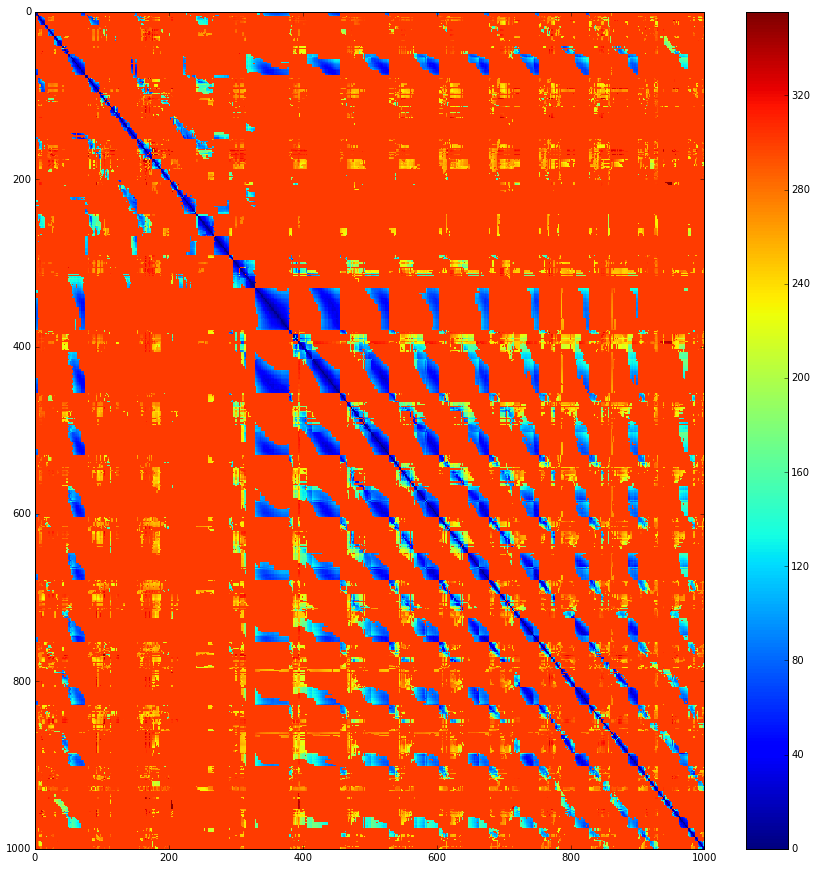

In [96]:
f = plt.figure()
plt.set_cmap('jet')
plt.rcParams['figure.figsize'] = (10.0, 10.0)
im = plt.pcolor(distmat)
plt.gca().invert_yaxis()
# plt.axes().set_aspect('equal', 'datalim')
# f.tight_layout()
f.colorbar(im)

### Compare to regular L2 difference between the images themselves

In [30]:

print_cutoff = 250
index_range = range(1000, 1999,5)

location = np.asarray([np.average(x), np.average(y)])

distmat_l2 = np.zeros((len(index_range),len(index_range)))

for t1 in range(len(index_range)):
    
    print index_range[t1]

    features1, bmp1 = loadData(index_range[t1], 0)
    
    bmp_cropped1 = np.asarray(bmp1[y[0]:y[1], x[0]:x[1]])
    bmp_cropped1 = bmp_cropped1.astype(np.int)
    

    for t2 in range(t1, len(index_range)):

        features2, bmp2 = loadData(index_range[t2], 0)
        
        bmp_cropped2 = np.asarray(bmp2[y[0]:y[1], x[0]:x[1]])
        bmp_cropped2 = bmp_cropped2.astype(np.int)

        distmat_l2[t1,t2] = math.sqrt(np.sum(np.square(bmp_cropped1 - bmp_cropped2)))
        
#         print "(%d, %d) = %0.2f" % (t1, t2, distmat_l2[t1,t2])
            
distmat_l2 = distmat_l2 + distmat_l2.T


1000
1005
1010
1015
1020
1025
1030
1035
1040
1045
1050
1055
1060
1065
1070
1075
1080
1085
1090
1095
1100
1105
1110
1115
1120
1125
1130
1135
1140
1145
1150
1155
1160
1165
1170
1175
1180
1185
1190
1195
1200
1205
1210
1215
1220
1225
1230
1235
1240
1245
1250
1255
1260
1265
1270
1275
1280
1285
1290
1295
1300
1305
1310
1315
1320
1325
1330
1335
1340
1345
1350
1355
1360
1365
1370
1375
1380
1385
1390
1395
1400
1405
1410
1415
1420
1425
1430
1435
1440
1445
1450
1455
1460
1465
1470
1475
1480
1485
1490
1495
1500
1505
1510
1515
1520
1525
1530
1535
1540
1545
1550
1555
1560
1565
1570
1575
1580
1585
1590
1595
1600
1605
1610
1615
1620
1625
1630
1635
1640
1645
1650
1655
1660
1665
1670
1675
1680
1685
1690
1695
1700
1705
1710
1715
1720
1725
1730
1735
1740
1745
1750
1755
1760
1765
1770
1775
1780
1785
1790
1795
1800
1805
1810
1815
1820
1825
1830
1835
1840
1845
1850
1855
1860
1865
1870
1875
1880
1885
1890
1895
1900
1905
1910
1915
1920
1925
1930
1935
1940
1945
1950
1955
1960
1965
1970
1975
1980
1985
1990
1995


<matplotlib.colorbar.Colorbar instance at 0x1334fa5a8>

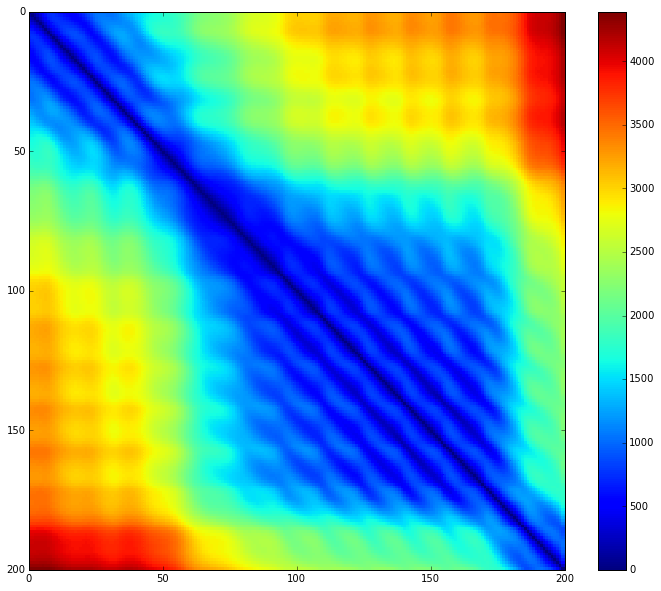

In [36]:
f = plt.figure()
plt.rcParams['figure.figsize'] = (10.0, 10.0)
im = plt.pcolor(distmat_l2)
plt.gca().invert_yaxis()
f.colorbar(im)